In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [2]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [112]:
#set default styling for plots
sns.set(style='ticks', context='talk')
sns.set_style("dark")

In [6]:
#load the train and test sets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Inspect Train + Test Sets
Summary: From this inspection, we see that there are five columns that contain nulls, with the monthly rent payment column ('v2a1') having the higheset null count. We also see that the test data set is 2.5 times the size of the training data set. There are 142 features in the training data set.

In [8]:
len(train)

9557

In [9]:
len(test)

23856

In [29]:
train.shape

(9557, 143)

In [30]:
test.shape

(23856, 142)

In [10]:
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [11]:
test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


In [25]:
null_columns_train = train.columns[train.isnull().any()]
print(train[null_columns_train].isnull().sum())

v2a1         6860
v18q1        7342
rez_esc      7928
meaneduc        5
SQBmeaned       5
dtype: int64


In [28]:
null_columns_test = test.columns[test.isnull().any()]
print(test[null_columns_test].isnull().sum())

v2a1         17403
v18q1        18126
rez_esc      19653
meaneduc        31
SQBmeaned       31
dtype: int64


## Exploratory Data Analysis
### Household Size
The household feature ('tamhog') skews right and the median household size is 4 people. The non-vulnerable households tend to have 2-4 people, whereas the extreme poverty households tend to have more than 6 people living in the house. This shows that household size could be a strong feature for helping predict poverty level. Extreme poverty peaks at 10-14 people in the household, whereas moderate poverty peaks at 5-6 people. Vulnerable poverty decreases as the household size grows, giving way to a rise in moderate and extreme poverty.

Text(0.5,0,'Size of Household')

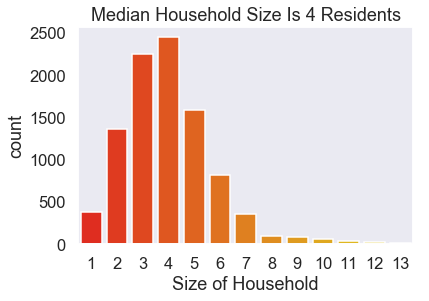

In [96]:
sns.countplot(train['tamhog'][train['tamhog'].notnull()], palette=("autumn"))
plt.title('Median Household Size Is 4 Residents')
plt.xlabel('Size of Household')

Text(0.5,0,'Size of Household')

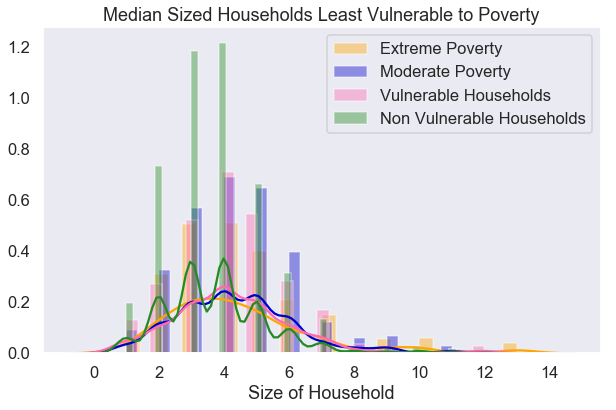

In [164]:
def distplot(feature):
    fig, ax = plt.subplots(1,1,figsize=(10,6))

    sns.distplot(train[feature][(train[feature].notnull())&(train['Target']==1)] ,color='orange', ax=ax)
    sns.distplot(train[feature][(train[feature].notnull())&(train['Target']==2)] ,color='mediumblue', ax=ax )
    sns.distplot(train[feature][(train[feature].notnull())&(train['Target']==3)] ,color='hotpink', ax=ax )
    sns.distplot(train[feature][(train[feature].notnull())&(train['Target']==4)] ,color='forestgreen', ax=ax )

    plt.legend(['Extreme Poverty', 'Moderate Poverty', 'Vulnerable Households', 'Non Vulnerable Households'])

distplot('tamhog')
plt.title('Median Sized Households Least Vulnerable to Poverty')
plt.xlabel('Size of Household')

Text(0.5,0,'Size of Household')

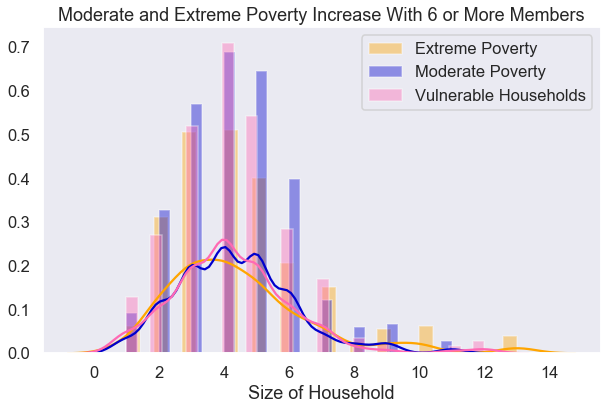

In [144]:
def distplot_vulnerable(feature):
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    
    sns.distplot(train[feature][(train[feature].notnull())&(train['Target']==1)] ,color='orange', ax=ax)
    sns.distplot(train[feature][(train[feature].notnull())&(train['Target']==2)] ,color='mediumblue', ax=ax)
    sns.distplot(train[feature][(train[feature].notnull())&(train['Target']==3)] ,color='hotpink', ax=ax )

    plt.legend(['Extreme Poverty', 'Moderate Poverty', 'Vulnerable Households'])

distplot_vulnerable('tamhog')
plt.title('Moderate and Extreme Poverty Increase With 6 or More Members')
plt.xlabel('Size of Household')

### Years of Schooling
The most common education levels are no schooling, 6 years of schooling and 11 years of schooling. As schooling increases, the vulnerability to poverty decreases according to the distplots. Extreme poverty is most prevalent in among people who have no schooling. Moderate poverty is most common among households with less than 6 years of schooling. The number of vulnerable households peak at 5 and 11 years of schooling, further indicating the trend that higher levels of education lead to less vulnerability to poverty.

Text(0.5,0,'Years of Schooling')

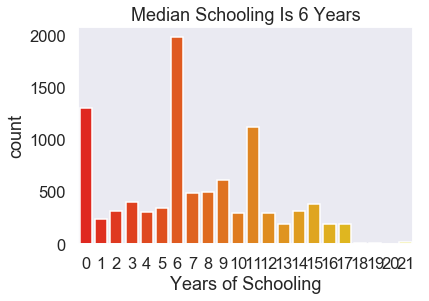

In [219]:
sns.countplot(train['escolari'][train['escolari'].notnull()], palette=("autumn"))
plt.title('Median Schooling Is 6 Years')
plt.xlabel('Years of Schooling')

Text(0.5,0,'Size of Household')

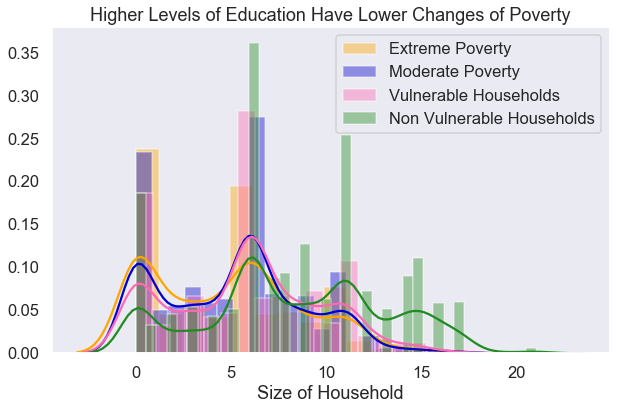

In [178]:
distplot('escolari')
plt.title('Higher Levels of Education Have Lower Changes of Poverty')
plt.xlabel('Years of Schooling')

Text(0.5,0,'Years of Schooling')

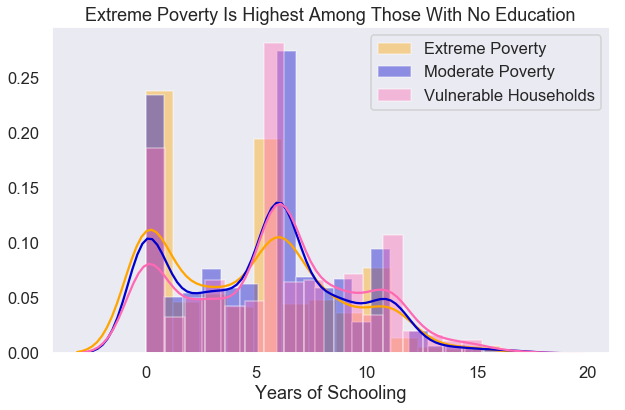

In [179]:
distplot_vulnerable('escolari')
plt.title('Extreme Poverty Is Highest Among Those With No Education')
plt.xlabel('Years of Schooling')

### Monthly Rent Payment
The distribution of rent payments skews right, with the most common rent payment being in the 1000,000 range. There are 6860 null values in the rent payment column, and 2697 populated values. The mean rent is 165,231 colon. Our analysis shows us that extreme poverty households tend to have lower monthly rent payments. Vulnerable households tend to have rent payments around the median value of 130,000 colon. This means that rent payments could be a good feature to help better predict poverty.

In [180]:
train['v2a1'].isnull().sum()

6860

In [234]:
train['v2a1'].dropna(inplace=True)
len(train['v2a1'])

2697

In [211]:
np.mean(train['v2a1'][train['v2a1'].notnull()])

165231.60697070821

In [237]:
np.median(train['v2a1'][train['v2a1'].notnull()])

130000.0

Text(0.5,0,'Rent in 100,000 Colon')

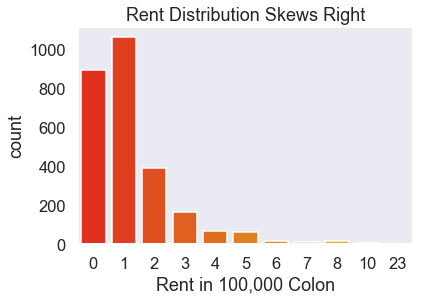

In [220]:
def rent_classify_int(x):
    return int(x/100000)

sns.countplot(train['v2a1'][train['v2a1'].notnull()].apply(rent_classify_int), palette=("autumn"))
plt.title('Rent Distribution Skews Right')
plt.xlabel('Rent in 100,000 Colon')

In [208]:
def rent_classify(x):
    return x/100000

train['rent'] = train['v2a1'][train['v2a1'].notnull()].apply(rent_classify)
train['rent'].value_counts().head()

1.5    233
1.0    181
2.0    159
1.2    149
0.5    118
Name: rent, dtype: int64

Text(0.5,0,'Rent in 100,000 Colon')

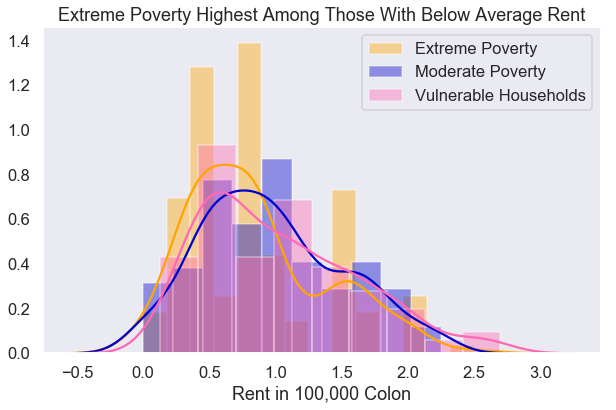

In [210]:
distplot_vulnerable('rent')
plt.title('Extreme Poverty Highest Among Those With Below Average Rent')
plt.xlabel('Rent in 100,000 Colon')